<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 10 October 2019, with material from Peadar Coyle, Gianluca Baio, and Marta Blangiardo</div>

# Bayesian Sport analytics

## Introduction


</br >
<center>
<img src="images/fifa2018.png" width=300 />
</center>

Sport analytics can be tougher than F1 because not all teams compete against each other ***at the same time***. The conclusions you draw from Germany beating Sweden depends how strong Sweden is, which in turn depends on the conclusions you draw from Sweden's other games, which in turn depends on how strong Sweden's opponents were, and so this problem is perfect for a **Bayesian model**. 

We want to infer the **latent** (latent means *hidden*) parameters (how strong a team is - that is hidden to us) that are driving the data we observe (scores), and be able to use these to predict future scores. We want to start with some prior distributions, and use some observations to refine our priors into posteriors. Scores are a noisy measurement of team strength, so quantifying team strength uncertainty is important. It will help us determine where to bet less (games we're weaker at predicting), and games to bet more on (games where uncertainty is minimal).

If you google `Bayesian football`, `Bayesian hierarchical model for the prediction of football results` shows up. Authors Gianluca Baio and Marta Blangiardo model Seria A football. Someone used this paper to build a model for rugby, but there's a  bug in their code and the model is quite wrong. At the end, they even conclude that there is no correlation between covariates even though pair plots show them to be correlated. Anyway, we are going to use their results and generate a (correct this time) model to put us in a better position to predict future scores. 

This is my version of a Sport Analytics notebook adapted from the rugby notebook by Peadar Coyle and the paper by Baio and Blangiardo, where I apply the theory to the round of 16 of World Cup 2014. Why 2014? Greece was in that World Cup! 

We will use a simple Poisson count model to model game scores.

<div style="text-align: right; color: gray">2</div>

## Regression from a Bayesian perspective (a bit of a review, as usual)

Regression from a Bayesian perspective requires us to think probabilistically.

To get the likelihood of our data given our assumptions about how it was generated, we must get the probability of each data point y according to the model we pick, and multiply them alltogether.

$$\text{likelihood} = p(y_1 \;|\; x_1, \theta)*p(y_2 \;|\; x_2, \theta)…*p(y_n \;|\; x_n, \theta)$$

We want to find values of $θ$ that maximize this result. That means that our model is highly probable to yield the data we observe. We want the parameters for ***that*** model, *dude*!

But we often work with the `log-likelihood` instead of the `likelihood` simply because it produces quanitities that do not underflow as easily. And because the `log` function is a monotonically increasing function, we know that maximizing the log of a value, with respect to some parameter, coincides with maximizing the value itself. `PyMC3` works with the log likelihood.

Now we use Bayes:

$$p(h \;|\; e) = \dfrac{p(e \;|\; h) * p(h)}{p(e)}$$

where $h$ is the hypothesis (our model parameters) and $e$ the evidence. You start with a prior belief about the hypothesis, then you gather evidence, and then you have a posterior belief.

$$\text{posterior} = \dfrac{\text{likelihood * prior}}{\text{marginal likelihood}}$$

That bottom line exhausts all possibilities with respect to hypothesss $h$, it boils down to $p(h)$. So event $h$ has been *marginalized out*. That is why $p(e)$ is also referred to as the **marginal likelihood**. It's the tough cookie to crack (the Metropolois algorithm gets rid of it in a smart way).

Bayesian methods are also *explicit* about uncertainty. They work with probability distritions, not point estimates. A hypothesis about parameters in a T-test are point estimates, but in Bayesian inference, hypotheses about parameters are distributed with a certain mean and some standard deviation (both of which get updated the more evidence you gather). So your prior is a distribution and your posterior is a distribution, and now you can naturally talk about confidence intervals as a function of the standard deviation, instead of artificially as with the T-test.

We then use MCMC methods to come up with the posterior distribution. And once we have our posterior, we are ready to predict. 

</br >
<center>
<img src="images/crystallball.png" width=300 />
</center>

In [1]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\Users\admin\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## The data

So I surfed the Web for a few hours for good data. I found a number of interesting Web sites:

* https://github.com/openfootball
* https://github.com/openfootball/world-cup
* Brazil 14 World Cup statistics such as time of posession, number of passes, attacking and defending parameters, etc: https://www.fifa.com/worldcup/archive/brazil2014/statistics/index.html
* Player data for Brazil 14 world cup: https://old.datahub.io/dataset/fifa-world-cup-2014-all-players
* Data for 2018 Kaggle competition: https://www.kaggle.com/ahmedelnaggar/fifa-worldcup-2018-dataset
* https://www.fifa.com/worldcup/archive/brazil2014/matches/index.html

But i just wanted a csv file with just scores. So I stumbled upon a file called `brazil14_scores.csv`, which is what i wanted. I forget from where, but i uploaded it to blackboard :-)

I copied it to my C:\Users\Dino\data folder, I injected it into a pandas data frame, and started poking around.

In [2]:
try:
    df_all = pd.read_csv('./data/brazil14_scores.csv')
except:
    df_all = pd.read_csv(pm.get_data('./data/brazil14_scores.csv'))

In [3]:
df_all

,match_number,location,created_at,status,home_team/country,home_team/code,home_team/goals,away_team/country,away_team/code,away_team/goals,winner,winner_code,home_team/penalties,away_team/penalties
0,1,Arena de Sao Paulo,1402603200000,completed,Brazil,BRA,3,Croatia,CRO,1,Brazil,BRA,NaN,NaN
1,2,Estadio das Dunas,1402675200000,completed,Mexico,MEX,1,Cameroon,CMR,0,Mexico,MEX,NaN,NaN
2,3,Arena Fonte Nova,1402686000000,completed,Spain,ESP,1,Netherlands,NED,5,Netherlands,NED,NaN,NaN
3,4,Arena Pantanal,1402696800000,completed,Chile,CHI,3,Australia,AUS,1,Chile,CHI,NaN,NaN
4,5,Estadio Mineirao,1402761600000,completed,Colombia,COL,3,Greece,GRE,0,Colombia,COL,NaN,NaN
5,6,Arena Pernambuco,1402794000000,completed,Ivory Coast,CIV,2,Japan,JPN,1,Ivory Coast,CIV,NaN,NaN
6,7,Estadio Castelao,1402772400000,completed,Uruguay,URU,1,Costa Rica,CRC,3,Costa Rica,CRC,NaN,NaN
7,8,Arena Amazonia,1402783200000,completed,England,ENG,1,Italy,ITA,2,Italy,ITA,NaN,NaN
8,9,Estadio Nacional,1402848000000,completed,Switzerland,SUI,2,Ecuador,ECU,1,Switzerland,SUI,NaN,NaN
9,10,Estadio Beira-Rio,1402858800000,completed,France,FRA,3,Honduras,HON,0,France,FRA,NaN,NaN


In [4]:
# results table
df_all['game'], df_all['difference'] = df_all['home_team/country'] + ' - ' + df_all['away_team/country'], df_all['home_team/goals'] - df_all['away_team/goals']
df_all['games'] = list(zip(df_all['game'], df_all['home_team/goals'], df_all['away_team/goals'], df_all['difference']))
df_all['games']

0                       (Brazil - Croatia, 3, 1, 2)
1                      (Mexico - Cameroon, 1, 0, 1)
2                   (Spain - Netherlands, 1, 5, -4)
3                      (Chile - Australia, 3, 1, 2)
4                      (Colombia - Greece, 3, 0, 3)
5                    (Ivory Coast - Japan, 2, 1, 1)
6                  (Uruguay - Costa Rica, 1, 3, -2)
7                       (England - Italy, 1, 2, -1)
8                  (Switzerland - Ecuador, 2, 1, 1)
9                      (France - Honduras, 3, 0, 3)
10    (Argentina - Bosnia and Herzegovina, 2, 1, 1)
11                        (Iran - Nigeria, 0, 0, 0)
12                    (Germany - Portugal, 4, 0, 4)
13                          (Ghana - USA, 1, 2, -1)
14                     (Belgium - Algeria, 2, 1, 1)
15               (Russia - Korea Republic, 1, 1, 0)
16                       (Brazil - Mexico, 0, 0, 0)
17                   (Cameroon - Croatia, 0, 4, -4)
18                        (Spain - Chile, 0, 2, -2)
19          

<div style="text-align: right; color: gray">4</div>

## Data exploration

Let's look at a few examples..

In [10]:
[game for game in list(zip(df_all['game'], df_all['home_team/goals'], df_all['away_team/goals'], df_all['difference'])) if "Germany" in game[0]]

[('Germany - Portugal', 4, 0, 4),
 ('Germany - Ghana', 2, 2, 0),
 ('USA - Germany', 0, 1, -1),
 ('Germany - Algeria', 2, 1, 1),
 ('France - Germany', 0, 1, -1),
 ('Brazil - Germany', 1, 7, -6),
 ('Germany - Argentina', 1, 0, 1)]

In [11]:
[game for game in list(zip(df_all['game'], df_all['home_team/goals'], df_all['away_team/goals'], df_all['difference'])) if "Spain" in game[0]]

[('Spain - Netherlands', 1, 5, -4),
 ('Spain - Chile', 0, 2, -2),
 ('Australia - Spain', 0, 3, -3)]

<div style="text-align: right; color: gray">5</div>
## Model based on point differentials

We use pandas' `groupby` API:

In [12]:
df_away_count = df_all.groupby('away_team/country')['difference'].count()
df_home_count = df_all.groupby('home_team/country')['difference'].count()
df_away_diff = df_all.groupby('away_team/country')['difference'].sum()
df_home_diff = df_all.groupby('home_team/country')['difference'].sum()
df_away_var = df_all.groupby('away_team/country')['difference'].var()
df_home_var = df_all.groupby('home_team/country')['difference'].var()
df_home_diff

home_team/country
Algeria                   0
Argentina                 4
Australia                -4
Belgium                   3
Bosnia and Herzegovina    2
Brazil                   -6
Cameroon                 -7
Chile                     2
Colombia                  6
Costa Rica                0
Croatia                  -2
Ecuador                   0
England                  -1
France                    4
Germany                   6
Ghana                    -1
Greece                    1
Honduras                 -4
Iran                      0
Italy                    -2
Ivory Coast               1
Japan                    -3
Korea Republic           -3
Mexico                    1
Netherlands               3
Nigeria                   0
Portugal                  1
Russia                    0
Spain                    -6
Switzerland              -2
USA                      -1
Uruguay                  -1
Name: difference, dtype: int64

The distribution of a sum of two normally distributed independent variates $X$ and $Y$ with means and variances $(μ_X,σ^2_X)$ and $(μ_Y,σ^2_Y)$, respectively is another normal distribution, with mean $μ_{X+Y} = μ_X + μ_Y$ and variance $σ^2_{X+Y} = σ^2_X + σ^2_Y$. You can verify this cool math result just by looking at the formula of a gaussian. 

We are not sure we have a normal distribution here, but if we take many games into account, by the Central Limit thoerem, we know we do! So we can look at **means** and **standard deviations**.

In [13]:
df_country_mean = (df_home_diff - df_away_diff)/(df_home_count + df_away_count)
df_country_std = np.sqrt(df_home_var.fillna(0) + df_away_var.fillna(0))/(df_home_count + df_away_count)
df_country_mean

home_team/country
Algeria                   0.000000
Argentina                 0.571429
Australia                -2.000000
Belgium                   0.600000
Bosnia and Herzegovina    0.000000
Brazil                   -0.428571
Cameroon                 -2.666667
Chile                     0.500000
Colombia                  1.600000
Costa Rica                0.600000
Croatia                   0.000000
Ecuador                   0.000000
England                  -0.666667
France                    1.400000
Germany                   2.000000
Ghana                    -0.666667
Greece                   -0.500000
Honduras                 -2.333333
Iran                     -1.000000
Italy                    -0.333333
Ivory Coast              -0.333333
Japan                    -1.333333
Korea Republic           -1.000000
Mexico                    0.500000
Netherlands               1.571429
Nigeria                  -0.500000
Portugal                 -1.000000
Russia                   -0.333333
Sp

and plot a picture:

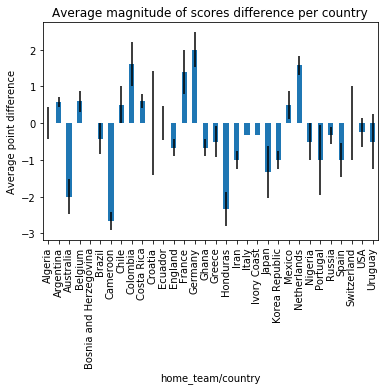

In [14]:
(df_country_mean

      .plot(kind='bar', title='Average magnitude of scores difference per country', yerr=df_country_std)
      .set_ylabel('Average point difference'));

See the good teams emerge?

</br >
<center>
<img src="images/droopy_ok.png" width=100 />
</center>

<div style="text-align: right; color: gray">6</div>

## Building a Bayesian Model

We know that a count outcome is most often modelled as a Poisson distribution. Modeling team strengths is usually accomplished with a vector of goals scored $y=(y_1,y_2)$ as independent Poisson distributions: $(y_i\;|\;θ_j) \propto Poisson(θ_j)$ where the $\theta_j$ parameters represent the scoring intensity for the team playing at home ($j=1$) and away ($j=2$), respectively.

We will model $\theta$ as an exponential of two independent variables: an attack variable **att**, and a defense variable **def**, times a constant factor k:

$$θ = k * e^{\text{att}_g} * e^{\text{def}_g}$$

We use an exponential to increase the effect of each indendent variable.

So we will use $log(\theta)$ to simplify calculations.

Since the home team has an advantage over the away team, these parameters are initially modeled with a log-linear random effect model, a standard procedure in sports analytics, and what we saw in class (except we take the **log**, and we have **discrete variables** rather than **continuous variables**).

$$\log(θ_1) = \text{home} + \text{att}_g + \text{def}_g \\
\log(θ_2) = \text{att}_g + \text{def}_g$$

The parameter `home` (the **intercept**) represents the *bias*: An advantage for the team hosting the cup, constant for all teams. 

The scoring intensity is determined jointly by an attack and a defense ability for each team, represented by parameters `att` and `def`, respectively

For each team $t = 1, \cdots, T$, team-specific attack and defense effects are modelled from a common normal distribution:
$att_t \propto \text{Normal}(μ_{att},τ_{att})$ and $def_t \propto \text{Normal}(μ_{def}, τ_{def})$.

We build a simple model in `PyMC3`, specifying global parameters, team-specific parameters, and the likelihood function.

In [49]:
df_all

,match_number,location,created_at,status,home_team/country,home_team/code,home_team/goals,away_team/country,away_team/code,away_team/goals,winner,winner_code,home_team/penalties,away_team/penalties,game,difference,games
0,1,Arena de Sao Paulo,1402603200000,completed,Brazil,BRA,3,Croatia,CRO,1,Brazil,BRA,NaN,NaN,Brazil - Croatia,2,"(Brazil - Croatia, 3, 1, 2)"
1,2,Estadio das Dunas,1402675200000,completed,Mexico,MEX,1,Cameroon,CMR,0,Mexico,MEX,NaN,NaN,Mexico - Cameroon,1,"(Mexico - Cameroon, 1, 0, 1)"
2,3,Arena Fonte Nova,1402686000000,completed,Spain,ESP,1,Netherlands,NED,5,Netherlands,NED,NaN,NaN,Spain - Netherlands,-4,"(Spain - Netherlands, 1, 5, -4)"
3,4,Arena Pantanal,1402696800000,completed,Chile,CHI,3,Australia,AUS,1,Chile,CHI,NaN,NaN,Chile - Australia,2,"(Chile - Australia, 3, 1, 2)"
4,5,Estadio Mineirao,1402761600000,completed,Colombia,COL,3,Greece,GRE,0,Colombia,COL,NaN,NaN,Colombia - Greece,3,"(Colombia - Greece, 3, 0, 3)"
5,6,Arena Pernambuco,1402794000000,completed,Ivory Coast,CIV,2,Japan,JPN,1,Ivory Coast,CIV,NaN,NaN,Ivory Coast - Japan,1,"(Ivory Coast - Japan, 2, 1, 1)"
6,7,Estadio Castelao,1402772400000,completed,Uruguay,URU,1,Costa Rica,CRC,3,Costa Rica,CRC,NaN,NaN,Uruguay - Costa Rica,-2,"(Uruguay - Costa Rica, 1, 3, -2)"
7,8,Arena Amazonia,1402783200000,completed,England,ENG,1,Italy,ITA,2,Italy,ITA,NaN,NaN,England - Italy,-1,"(England - Italy, 1, 2, -1)"
8,9,Estadio Nacional,1402848000000,completed,Switzerland,SUI,2,Ecuador,ECU,1,Switzerland,SUI,NaN,NaN,Switzerland - Ecuador,1,"(Switzerland - Ecuador, 2, 1, 1)"
9,10,Estadio Beira-Rio,1402858800000,completed,France,FRA,3,Honduras,HON,0,France,FRA,NaN,NaN,France - Honduras,3,"(France - Honduras, 3, 0, 3)"


In [26]:
df = df_all[['home_team/country', 'away_team/country', 'home_team/goals', 'away_team/goals']]
df.head()

,home_team/country,away_team/country,home_team/goals,away_team/goals
0,Brazil,Croatia,3,1
1,Mexico,Cameroon,1,0
2,Spain,Netherlands,1,5
3,Chile,Australia,3,1
4,Colombia,Greece,3,0


In [27]:
teams = df['home_team/country'].unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams


,team,i
0,Brazil,0
1,Mexico,1
2,Spain,2
3,Chile,3
4,Colombia,4
5,Ivory Coast,5
6,Uruguay,6
7,England,7
8,Switzerland,8
9,France,9


In [28]:
df = pd.merge(df, teams, left_on='home_team/country', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team/country', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head(10)

,home_team/country,away_team/country,home_team/goals,away_team/goals,i_home,i_away
0,Brazil,Croatia,3,1,0,24
1,Mexico,Cameroon,1,0,1,16
2,Spain,Netherlands,1,5,2,25
3,Chile,Australia,3,1,3,17
4,Colombia,Greece,3,0,4,26
5,Ivory Coast,Japan,2,1,5,18
6,Uruguay,Costa Rica,1,3,6,27
7,England,Italy,1,2,7,19
8,Switzerland,Ecuador,2,1,8,28
9,France,Honduras,3,0,9,20


In [29]:
observed_home_goals = df['home_team/goals'].values
observed_away_goals = df['away_team/goals'].values

home_team = df['i_home'].values
away_team = df['i_away'].values

num_teams = len(teams)
num_games = len(home_team)
num_teams, num_games

(32, 64)

In [20]:
home_team

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,
       16,  2, 17,  4, 18,  6, 19,  8, 20, 10, 21, 12, 22, 14, 23, 16, 24,
       17, 25, 18, 26, 19, 27, 20, 28, 21, 29, 22, 30, 23, 31,  0,  4, 25,
       27,  9, 12, 10, 14,  0,  9, 25, 10,  0, 25,  0, 12], dtype=int64)

In [21]:
observed_home_goals = df['home_team/goals'].values
observed_home_goals

array([3, 1, 1, 3, 3, 2, 1, 1, 2, 3, 2, 0, 4, 1, 2, 1, 0, 0, 0, 2, 2, 0,
       2, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, 3,
       0, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1],
      dtype=int64)

These are our priors for the `att` and `def` parameters for each team.

In [22]:
g1 = df.groupby('i_away')
att_starting_points = np.log(g1['away_team/goals'].mean())
g2 = df.groupby('i_home')
def_starting_points = -np.log(g2['home_team/goals'].mean())
def_starting_points
# to replace inf's with zeros:
#list(map(lambda x: 0 if np.isinf(x) else x, def_starting_points))

i_home
0    -0.154151
1    -0.000000
2     0.693147
3    -1.098612
4    -0.847298
5    -0.693147
6    -0.405465
7    -0.000000
8    -0.693147
9    -0.510826
10   -0.223144
11         inf
12   -0.810930
13   -0.000000
14   -0.510826
15   -0.000000
16    0.693147
17   -0.000000
18    0.693147
19         inf
20    0.693147
21   -0.405465
22   -0.000000
23   -0.000000
24   -0.000000
25   -0.000000
26   -0.693147
27    0.693147
28         inf
29   -1.098612
30   -0.693147
31   -0.000000
Name: home_team/goals, dtype: float64

<div style="text-align: right; color: gray">7</div>
Ok, we have our priors, now let's specity our model and likelihood function in `pymc3`. Note: you could also do this with `Sampyl` or [RStan](http://mc-stan.org/users/documentation/case-studies/rstan_workflow.html) (there is a direct port of RStan to Python).

You should know that whenever we have a small number of data point (about 30 or less), the [t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) gives better results than the normal distribution. 

If you are modeling the distribution of a *large* population, then use the **normal distribution**. If you are modeling the mean of the population when the population size is small, better to use the t-distribution, also called the **student-t distribution**.

The student-t distribution has higher kurtosis (4th *moment*) than the normal distribution. That means that data from the t-distribution will have a tendency to appear closer or farther from the mean (it's like your rear-view mirro: ***objects are closer than they appear*** :-):-)) than typical normal data, with a more sudden transition in between. In other words, the t-distribution is more *fat-tailed* and captures outliers ***better***: The probability of obtaining values far from the mean is larger than with the normal distribution.

As the number of degrees of freedom of data increases, the t-distribution becomes closer to the normal distribution. The t-distribution is used a lot in [fintech](https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-7701-4_18). Financial data does tend to have higher kurtosis than the normal distribution, and exhibits wild jumps up or down  more frequently than what the normal distribution predicts.

The **half-t distribution** (also denoted **folded-t**) is derived from the t-distribution by taking the absolute values of variates. Since we already know the sign of `att` and `def` parameters, we don't want any negative signs.

Since we have a linear model for log$\theta$, we have a *slope-intercept* formula: $y = mx + b$ where $m$ is the slope or the consistent change between $x$ and $y$, and $b$ is the y-intercept (intercepts the y-axis at $y = b$). It is the expected mean value of $y$ when $x = 0$.

So here's the model and likelihood in `pymc3`:

In [32]:
with pm.Model() as model:
    # global model priors: standard deviation and intercept.
    # We are saying that the standard deviation and intercept priors of each
    # team's att and def parameters stem from the same folded-t distribution.
    # You need to match these to the real priors above - I did not do this because
    # i'm lazy. I just picked a nu and sd out of my hat :-)
    # Note use of student-t because we only have 32 teams, low number.
    home = pm.Flat('home') #flat pdf is uninformative - means we have no idea
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept') #no idea

    # team-specific model parameters. There is one (atts_star, defs_star) tuple per team.
    # Note use of normal distribution because we assume we have a lot of data per team
    # (not really here, but *you* should!)
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)

    # To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects
    # We save these parameters for later exploration.
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    
    # Assume exponential search on home_theta and away_theta. With pymc3, need to rely on theano.
    # tt is theano.tensor.. why Sampyl may be easier to use..
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])  
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data, Poisson distribution for coutn data, always!
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Run! A *trace* is an MCMC sampling of your posterior probability distribution. It yields the parameters of your model (`att` and `def` per team, for a log-linear model) that are most likely to fit your observations. We won't specify an algorithm; pymc3 will most likely choose NUTS.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 2 chains: 100%|██████████| 4000/4000 [07:13<00:00,  5.09draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
D:\Users\admin\Anaconda3\lib\site-packages\arviz\plots\traceplot.py:155: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (132), generating only 40 plots
  SyntaxWarning,


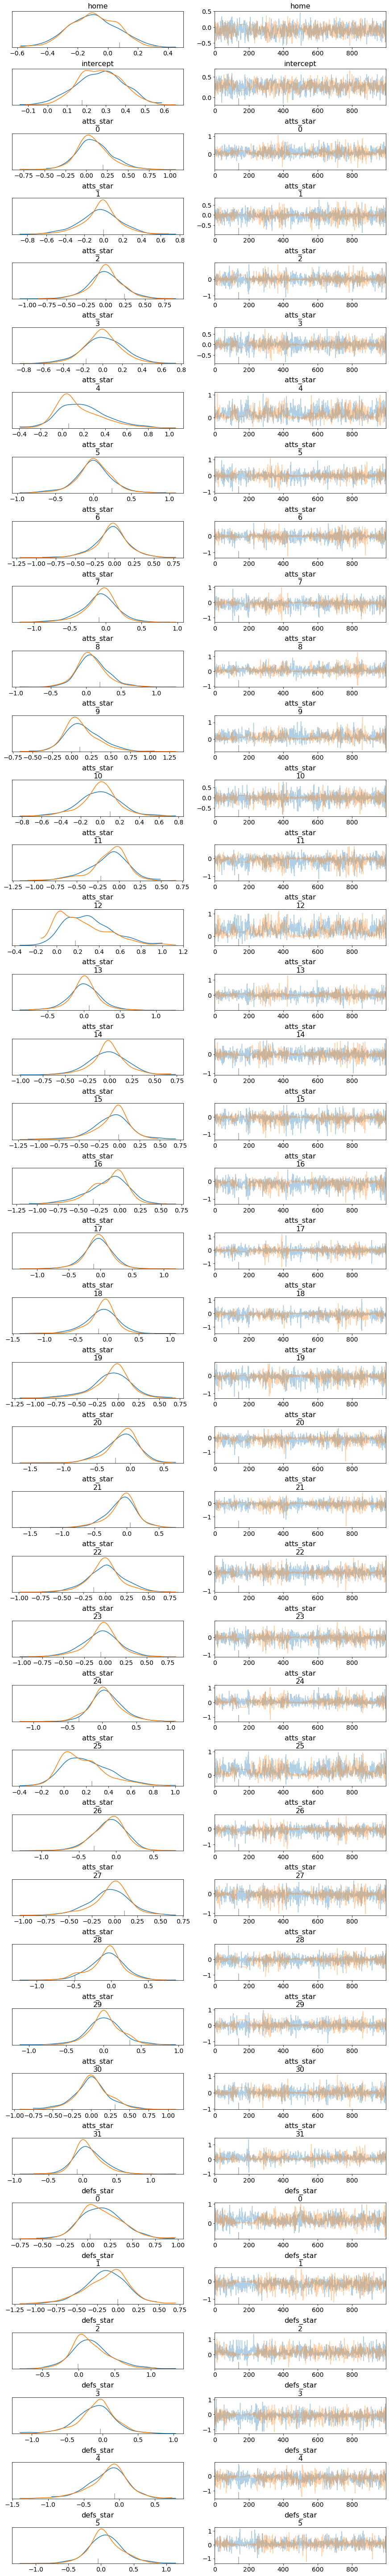

In [33]:
with model:
    trace = pm.sample(1000, tune=1000, cores=2)
    pm.traceplot(trace)

<div style="text-align: right; color: gray">8</div>

## Plotting

Let's plot team attacking strengths, with **credible intervals**, so we have uncertainty quantification of our estimate of teams' strengths.

In Bayesian statistics, a *credible interval* is a range of values within which an unobserved parameter value falls with a particular subjective probability. It is an interval in the domain of a posterior probability distribution or a predictive distribution.

Credible intervals are analogous to **confidence intervals** in the frequentist statistics we studied when we studied the t-test, remember?

Bayesian intervals treat bounds as *fixed* and the estimated parameter as a *random variable*. In our experiment to determine the distribution of team strength `att`, if the subjective probability that `att`$_{germany}$ lies between 0.35 and 0.55 is 0.95, then $0.35\leq \text{att} \leq 0.55$ is a 95% credible interval.

Frequentist confidence intervals treat bounds as random variables and the parameter as a fixed value. A frequentist 95% confidence interval means that with a large number of repeated samples, 95% of such calculated confidence intervals would include the true value of the parameter. Aren't Bayesian credible intervals a much better metric? I think they are. However, Bayesian credible intervals do require knowledge of a situation-specific prior distribution, while frequentist confidence intervals do not.

The **highest posterior density interval** (HDI) is the interval which contains the required point estimate such that all points within the interval have a higher probability density than points outside the interval. The HDI is the narrowest interval containing the specified point estimate. Locating the HDI is usually accomplished using the Chen-Shao algorithm (Chen and Shao; 1999; Chen, Shao, and Ibrahim; 2000). For more info, this is the best [reference](https://cran.r-project.org/web/packages/HDInterval/HDInterval.pdf) i've found. In `pymc3`, you get it with `stats.hpd`.

**Quantiles** are sets of values of a variate that divide a frequency distribution into equal groups, each containing the same fraction of the total population. The *Median*, below, is an example of a quantile that separates the two halves of a group.

</br >
<center>
<img src="images/median.png" width=200 />
</center>

Ok, ready for our model estimates?

In [34]:
pm.stats.hpd(trace['atts'])

array([[-0.30269392,  0.50666562],
       [-0.46690197,  0.35292363],
       [-0.42465871,  0.44458575],
       [-0.37586837,  0.39869494],
       [-0.21120143,  0.64647774],
       [-0.4319265 ,  0.5001847 ],
       [-0.45000261,  0.40613684],
       [-0.56339455,  0.37318047],
       [-0.31502446,  0.5344407 ],
       [-0.2443814 ,  0.58549327],
       [-0.47457572,  0.35553203],
       [-0.64652648,  0.29567315],
       [-0.12235683,  0.73188062],
       [-0.45001934,  0.41879172],
       [-0.42040243,  0.40818665],
       [-0.56505616,  0.37160349],
       [-0.64169848,  0.28661264],
       [-0.48217058,  0.41276967],
       [-0.54232235,  0.41953946],
       [-0.58250688,  0.35911578],
       [-0.63484934,  0.30990378],
       [-0.52833322,  0.35703551],
       [-0.41483319,  0.43237355],
       [-0.49029288,  0.36210154],
       [-0.35683305,  0.55125682],
       [-0.12332457,  0.65410223],
       [-0.5274395 ,  0.35758975],
       [-0.53627673,  0.33639964],
       [-0.51142478,

In [35]:
pm.stats.quantiles(trace['atts'])

{2.5: array([-0.28782168, -0.47568419, -0.430128  , -0.39886318, -0.17789392,
        -0.49292873, -0.48836564, -0.5906231 , -0.30834235, -0.21135482,
        -0.43939977, -0.68763719, -0.06939319, -0.44026111, -0.439055  ,
        -0.63832204, -0.70262055, -0.54131897, -0.63455583, -0.62950511,
        -0.67740927, -0.54628807, -0.43292463, -0.49918251, -0.33743571,
        -0.11809997, -0.583297  , -0.53117765, -0.52449895, -0.41627172,
        -0.43957646, -0.29359093]),
 25: array([-0.03399752, -0.1414191 , -0.10701651, -0.11533232,  0.02386532,
        -0.10973337, -0.13344585, -0.20104603, -0.03964509, -0.00776878,
        -0.11559832, -0.2264352 ,  0.08683358, -0.09145515, -0.1209141 ,
        -0.208048  , -0.28895783, -0.1411418 , -0.19559383, -0.1936433 ,
        -0.24938474, -0.17965523, -0.11179603, -0.15117957, -0.06790502,
         0.04027063, -0.2258357 , -0.16159119, -0.17953232, -0.10178497,
        -0.10098582, -0.04145585]),
 50: array([ 6.81469436e-02, -1.32019648e-0

In [1]:
teams.team.values

NameError: name 'teams' is not defined

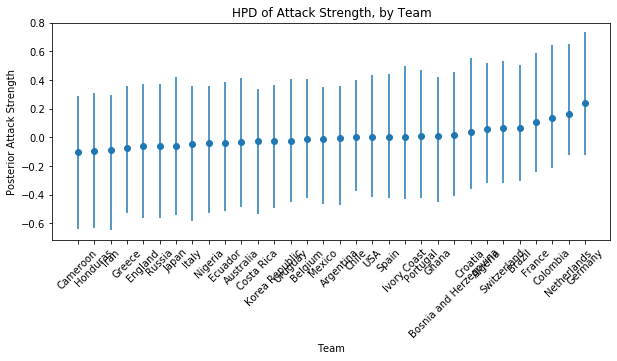

In [36]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['atts'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

Greece is well behind Netherlands and Germany in attacking strength.

</br >
<center>
<img src="ipynb.images/sadface.png" width=300 />
</center>

However, in defense..

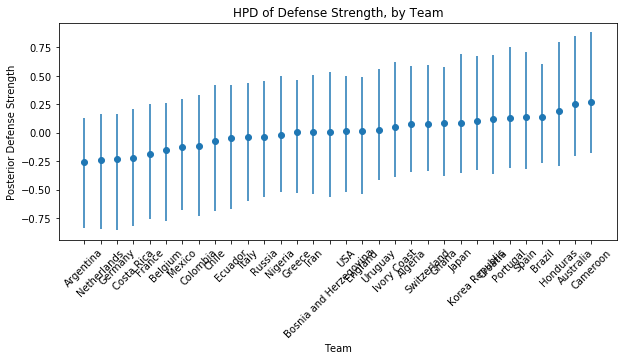

In [37]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['defs']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['defs'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Defense Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defense Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

We expect strong teams to have strong positive effects in attack and strong negative effects in defense. See how Greece is stronger than USA in defense! But we already knew that of greek soccer. Look who's #25 in the list of [top defensive](https://bleacherreport.com/articles/2165947-ranking-europes-top-25-clubs-on-their-defensive-strength#slide1) clubs in Europe for 2014.

Here are the 95% highest posterior density intervals for the attack strength for each team.

In [38]:
teams.T


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
team,Brazil,Mexico,Spain,Chile,Colombia,Ivory Coast,Uruguay,England,Switzerland,France,...,USA,Korea Republic,Croatia,Netherlands,Greece,Costa Rica,Ecuador,Bosnia and Herzegovina,Portugal,Algeria
i,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31


D:\Users\admin\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


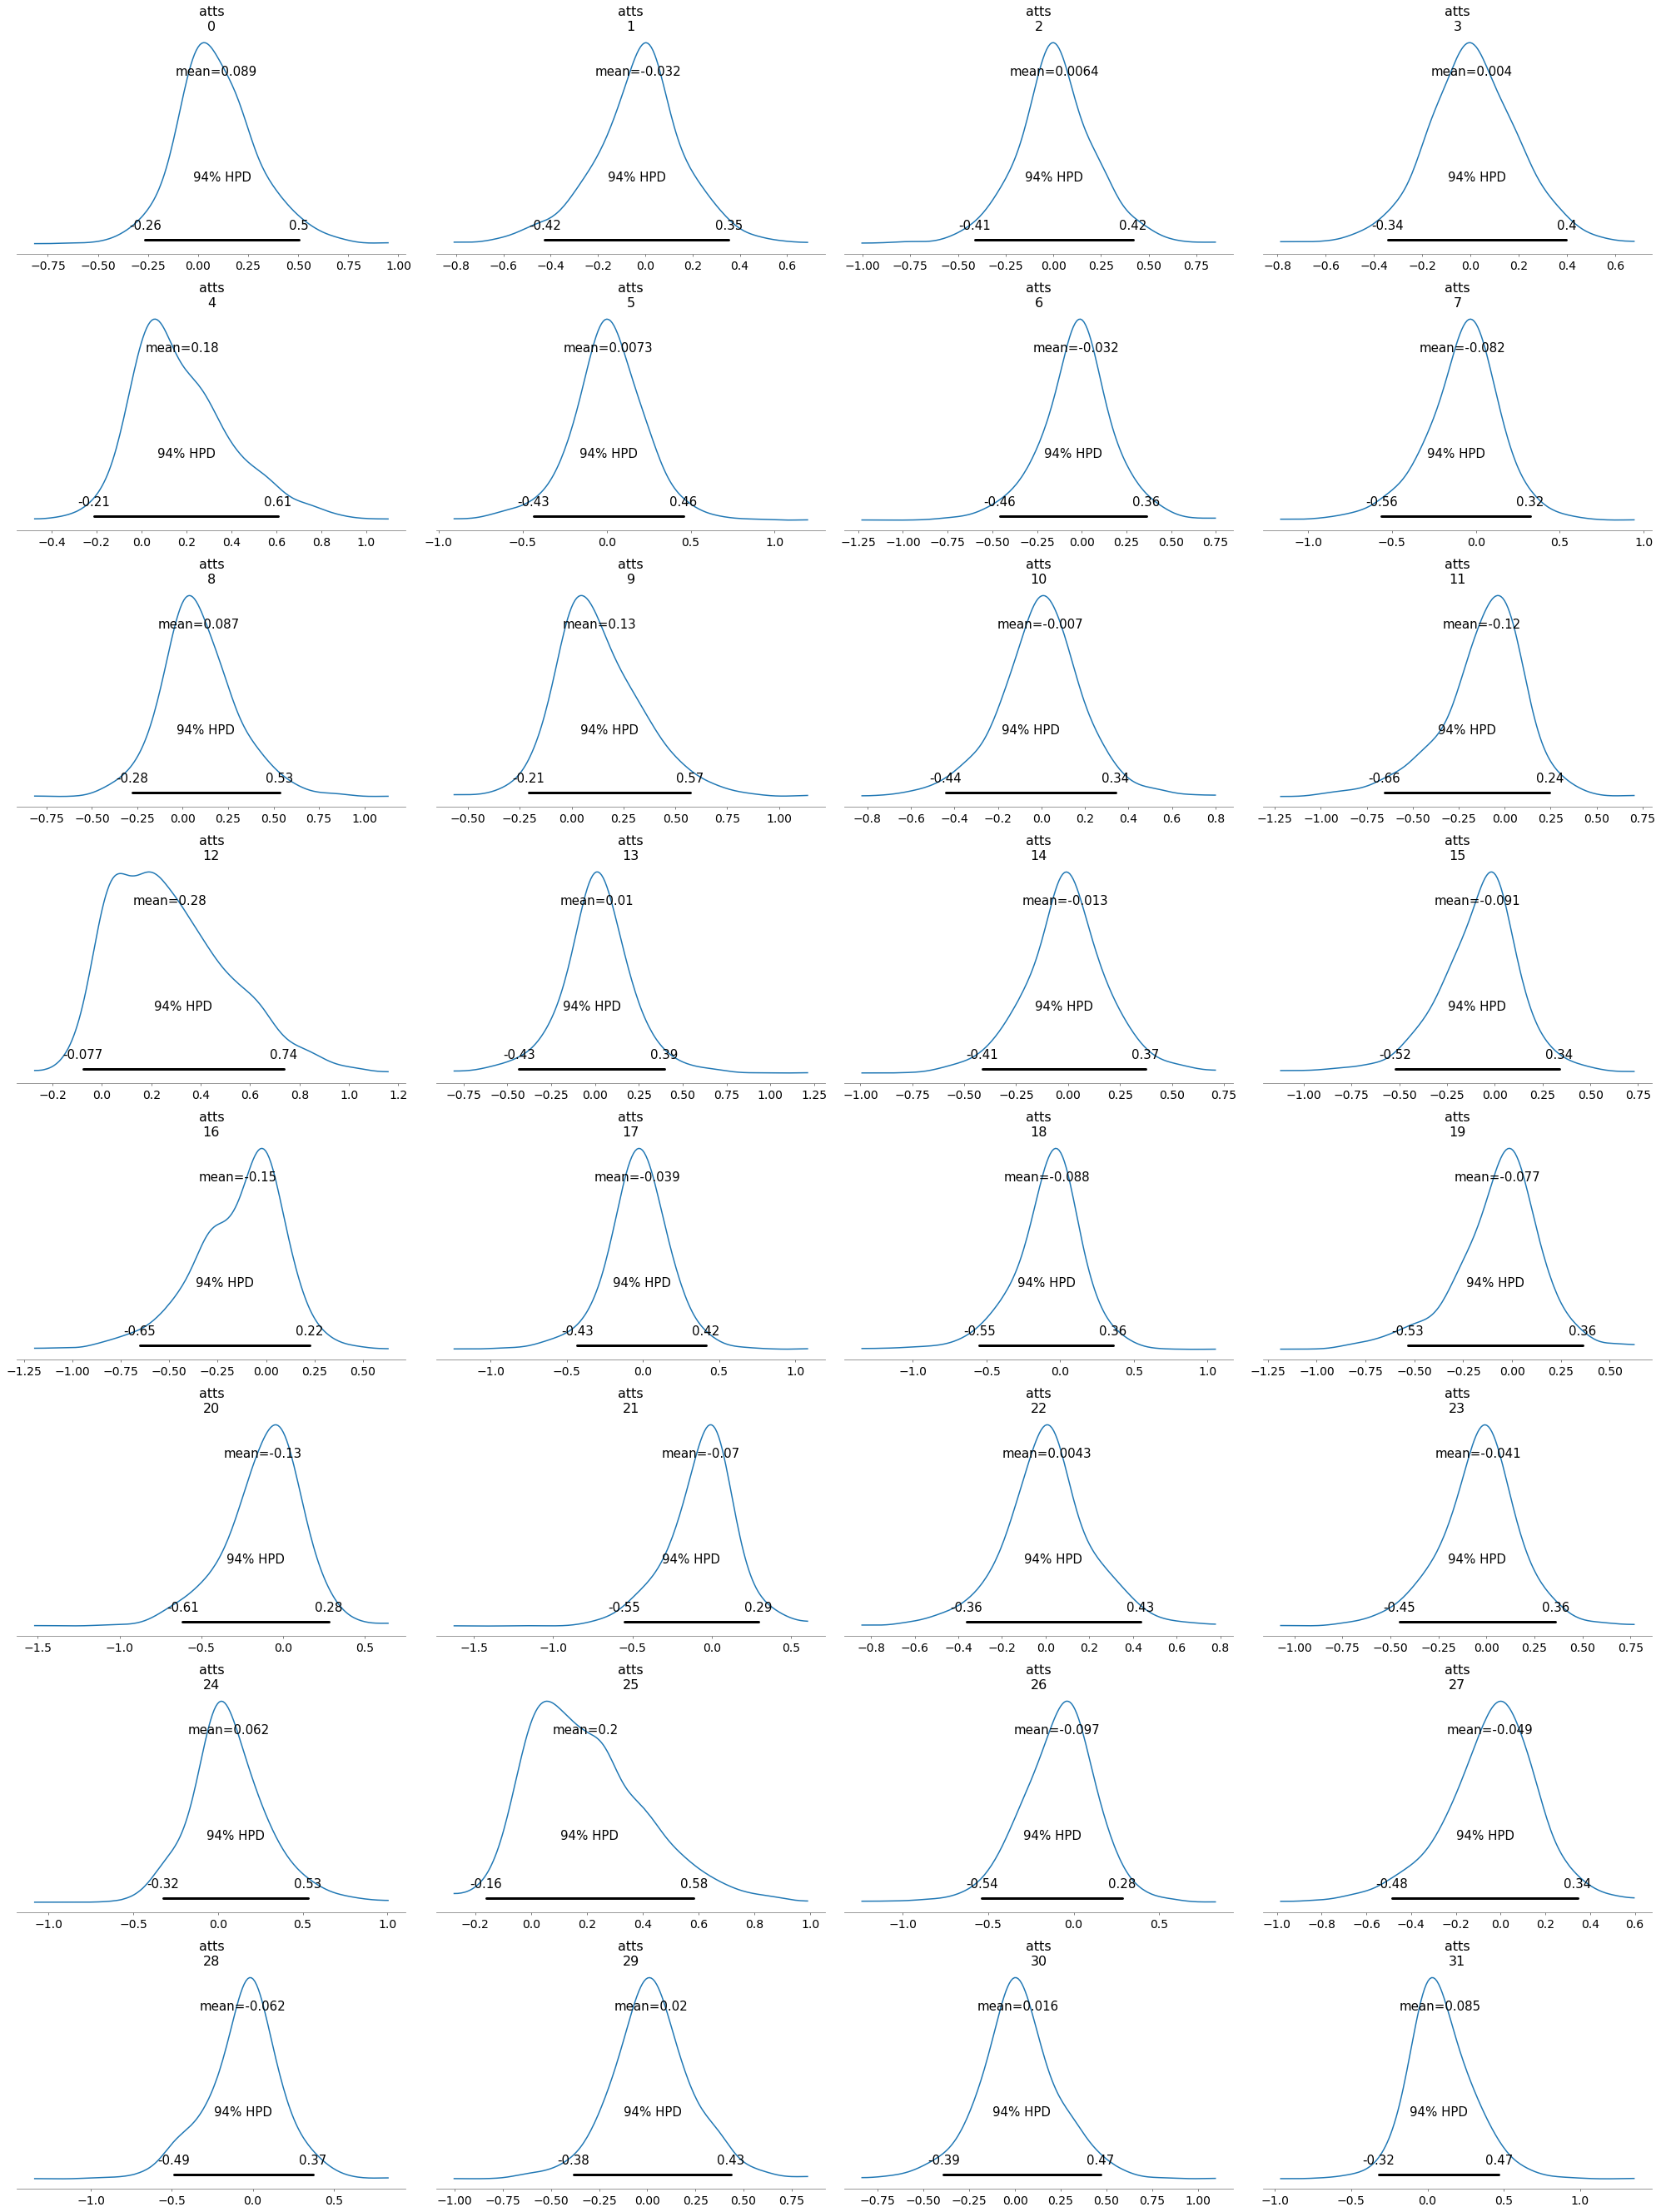

In [39]:
pm.plot_posterior(trace, varnames=['atts']);

Let's compare Germany (#12) and Greece (#26). 

$\mu_{germany}^{att} = 0.3$ while $\mu_{greece}^{att} = -0.103$. 

Germany has a strong positive attacking effect of 0.3, while Greece has a weak *negative* attacking effect of -0.103. This says you expect Germany to score, while you expect Greece not to score.

There are many other priors we could bring into this, such as world ranking, or by player strength, etc.

Now let’s simulate wins over 1000 World Cups!

<div style="text-align: right; color: gray">9</div>
## Predicting the future with Posterior Predictive Checks

**Posterior predictive checks** (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

PPCs can help analyze the degree to which data generated from the model deviate from data generated from the true distribution. Visualizing the PPC is a great ‘sense check’ of your model. In `pymc3`, it's done with `sample_ppc()` of your trace.

In [40]:
with model:
    pp_trace = pm.sample_ppc(trace)

D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 2000/2000 [00:03<00:00, 528.00it/s]


In [41]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * home_won
        for i, home_won in enumerate(pp_trace['home_points'] > pp_trace['away_points'])
})
home_sim_df.insert(0, 'team', df['home_team/country'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * away_won
        for i, away_won in enumerate(pp_trace['home_points'] < pp_trace['away_points'])
})
away_sim_df.insert(0, 'team', df['away_team/country'])

In [42]:
sim_table = (home_sim_df.groupby('team')
                        .sum()
                        .add(away_sim_df.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))

In [43]:
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0
team,,,,,,,,,,,,,,,,,,,,,
Algeria,0.046,0.067,0.080,0.087,0.118,0.149,0.145,0.105,0.055,0.021,...,0.037,0.061,0.073,0.083,0.063,0.038,0.015,0.004,0.001,0.000
Argentina,0.420,0.317,0.223,0.140,0.115,0.152,0.111,0.076,0.036,0.015,...,0.009,0.015,0.013,0.017,0.014,0.008,0.005,0.001,0.000,0.000
Australia,0.006,0.014,0.018,0.023,0.039,0.073,0.089,0.055,0.022,0.016,...,0.082,0.154,0.163,0.173,0.137,0.081,0.033,0.012,0.003,0.001
Belgium,0.149,0.206,0.197,0.156,0.158,0.158,0.139,0.102,0.048,0.029,...,0.010,0.024,0.031,0.048,0.027,0.016,0.003,0.001,0.000,0.000
Bosnia and Herzegovina,0.004,0.030,0.047,0.063,0.097,0.126,0.117,0.091,0.051,0.023,...,0.047,0.089,0.095,0.102,0.083,0.050,0.009,0.006,0.001,0.000
Brazil,0.247,0.211,0.180,0.142,0.126,0.170,0.144,0.099,0.035,0.018,...,0.015,0.038,0.037,0.039,0.022,0.015,0.009,0.001,0.000,0.001
Cameroon,0.002,0.010,0.020,0.030,0.046,0.065,0.073,0.048,0.027,0.019,...,0.079,0.147,0.157,0.165,0.157,0.092,0.030,0.005,0.002,0.000
Chile,0.058,0.121,0.151,0.120,0.141,0.166,0.163,0.108,0.069,0.023,...,0.020,0.048,0.041,0.046,0.037,0.024,0.008,0.003,0.000,0.000
Colombia,0.214,0.310,0.276,0.174,0.160,0.179,0.127,0.093,0.042,0.022,...,0.005,0.016,0.017,0.020,0.018,0.006,0.005,0.001,0.000,0.000


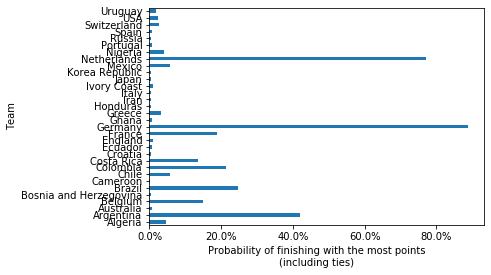

In [44]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points\n(including ties)");

ax.set_ylabel("Team");

So, Germany, Netherlands, and Argentina it is, according to the Brazil 14 World Cup model we concocted! According to this model, Germany finishes with the most points about 48% of the time, Netherlands finishes with the most points 38% of the time, and Argentina finishes with the most points about 20% of the time (Greece, about 1% of the time - I want to live in *that* universe!).

<div style="text-align: right; color: gray">10</div>

## Covariate exploration

Let's finish with some covariates exploration. The covariates here are the team-specific attackand defense strenth parameters as MCMC-sampled from their posterior distribution. Let's see if we can find correlations between attacking strengths for teams that are dear to my heart. 

We could, hypothetically, find that when Germany is strong, Greece is strong. That won't be the case in all likelihood (unless all greek players play in the Bundesliga). This is probably how you'd try to find patterns in stock market models. For example, gold futures are inversely proportional to bear markets. But we check nonetheless.

In [45]:
df_trace = pm.trace_to_dataframe(trace)

In [46]:
teams.T

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
team,Brazil,Mexico,Spain,Chile,Colombia,Ivory Coast,Uruguay,England,Switzerland,France,...,USA,Korea Republic,Croatia,Netherlands,Greece,Costa Rica,Ecuador,Bosnia and Herzegovina,Portugal,Algeria
i,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31


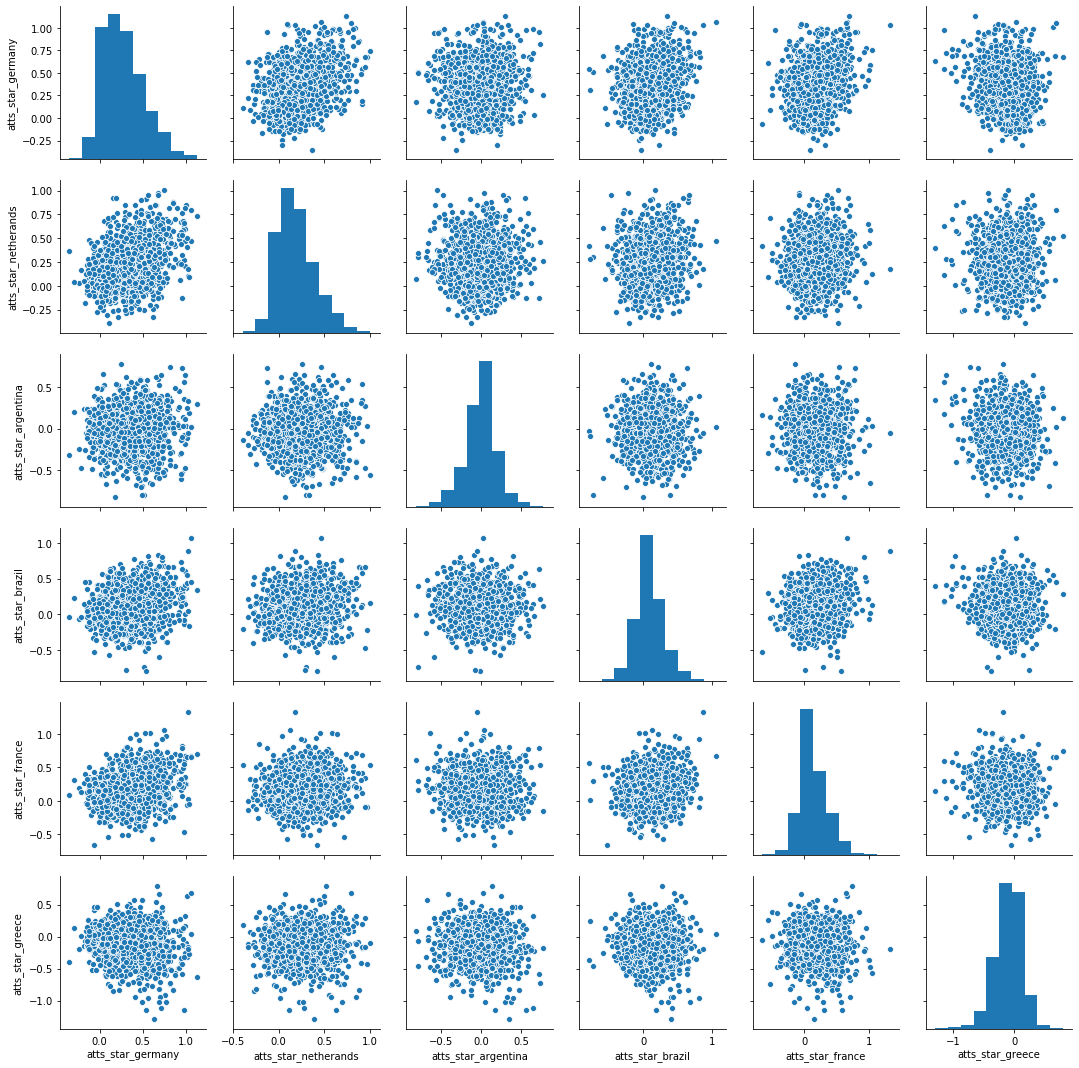

In [47]:
import seaborn as sns

cols = {
    'atts_star__12': 'atts_star_germany',
    'atts_star__25': 'atts_star_netherands',
    'atts_star__10': 'atts_star_argentina',
    'atts_star__0': 'atts_star_brazil',
    'atts_star__9': 'atts_star_france',
    'atts_star__26': 'atts_star_greece'
}

df_trace_att = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_att)

.. and defensive strengths:

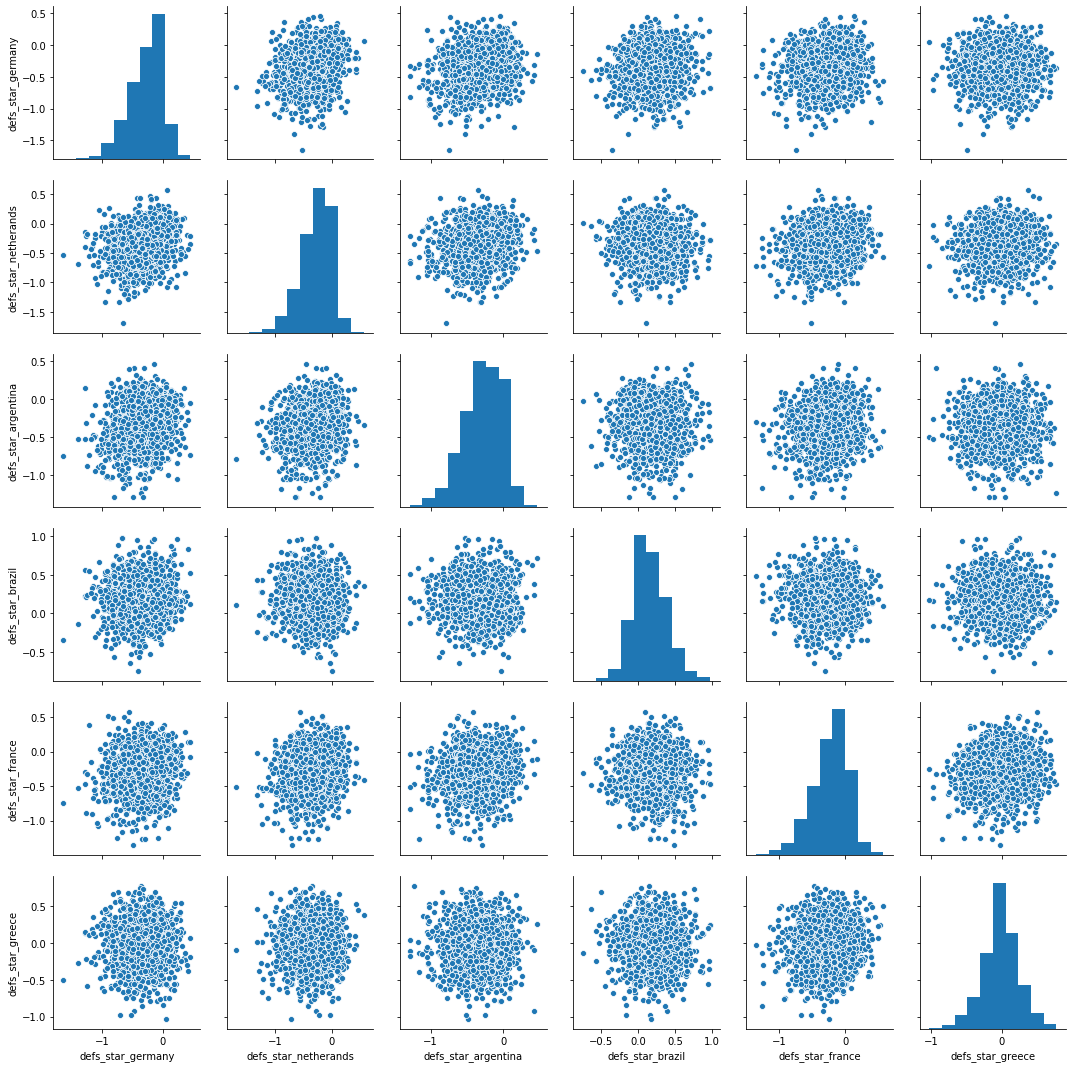

In [48]:
import seaborn as sns

cols = {
    'defs_star__12': 'defs_star_germany',
    'defs_star__25': 'defs_star_netherands',
    'defs_star__10': 'defs_star_argentina',
    'defs_star__0': 'defs_star_brazil',
    'defs_star__9': 'defs_star_france',
    'defs_star__26': 'defs_star_greece'
}

df_trace_def = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_def)

Both attack and defense covariates appear uncorrelated between teams, to me.

<div style="text-align: right; color: gray">11</div>

## Actually quite a hoax

We were able to *quantify* attacking and defensive strength of World Cup teams as parameters of a Bayesian model, together with credibility intervals, with data from World Cup Brazil 2014.

Even though this notebook helps you understand the procedure for Bayesian sport analytics, this notebook is a **hoax**, like many other notebooks out on the Web that evangelize ML (e.g. ones based on analysis of financial data)! You know why? What's our independent variable here? Attack and defense based on score differential scored, right? What's our covariate (dependent parameter, what we're modeling)? How many points the team is going to score, right? So we used score differentials as a basis to predict... probable scores. That is a hoax!

A correct model will use ***unrelated*** independent variables to model a variable of interest that is likely to be dependent.  But not so directly dependent that they are one and the same! So your job is to find a few uncorrelated variables to use as a Bayesian linear model for another variable you want to be able to predict. In baseball for example, you may use ERA and other player statistics to predict which team is going to win. There are many fantasy sports sites that keep score on many variables that you could use to build a sport-team bayesian model. 
</br >
<center>
<img src="ipynb.images/bosox.png" width=300 />
</center>